In [1]:
import ast
import gzip
import io
import json
import nilearn
import os
import sklearn
import tarfile
import tempfile
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from bids_validator import BIDSValidator

from fetch_difumo import fetch_difumo
from io import BytesIO
from pathlib import Path
from os import listdir as ls
from os.path import basename as bname
from os.path import dirname as dname
from os.path import expanduser as xpu
from os.path import join as pjoin
from pandas import DataFrame as df
from tempfile import TemporaryDirectory as tmpdir
from tempfile import TemporaryFile as tmpfile
from tqdm import tqdm
from typing import Union
from collections.abc import Iterable
from typing import Sequence

import loadutils as lu
import sniffbytes as snif
import scanzip as szip
import shutil

from nilearn import masking
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, plot_epi
from nilearn.image import concat_imgs, mean_img
from nilearn.input_data import NiftiMasker

def lst_intersection(lst1, lst2):
    '''
    Source: https://www.geeksforgeeks.org/python-intersection-two-lists/
    '''
    return [value for value in lst1 if value in set(lst2)]

def read_json(fpath:Union[str, os.PathLike]) -> dict:
    with open(fpath, mode='r', encoding='UTF-8') as jfile:
        jdict = json.load(jfile)
    jfile.close()
    return jdict
        
# with tmpfile(prefix=os.getcwd()+"/",
#             dir=os.path.splitext(bname(src_path))[0]+"/",
#             suffix=os.path.splitext(topname)[0]) as adir:
#     print(adir.name)
# tardir = xpu('~/../../data/cisl/DATA/cimaq_20190901/sourcedata')
# topname = 'cimaq_dicoms_20190901_v3.tar.gz'
# member = 'seriesUID_qc.tsv'
# tardir = '/media/francois/seagate_1tb/cimaq_dicoms_20190901'
# help(tempfile)
# src_path = pjoin(tardir, topname)
cimaq_nov_dir = xpu('~/../../data/cisl/DATA/cimaq_20190901')
cimaq_mar_dir = xpu('~/../../data/cisl/DATA/cimaq_03-19')
events_path = xpu('~/../../data/cisl/DATA/cimaq_corrected_events/events')
behav_path = xpu('~/../../data/cisl/DATA/cimaq_corrected_behavioural/behavioural')
participants_desc = read_json(fpath=pjoin(cimaq_mar_dir, 'participants.json'))
dataset_desc = read_json(fpath=pjoin(cimaq_mar_dir, 'dataset_description.json'))
# post_scan_desc = read_json(fpath=pjoin(cimaq_mar_dir, 'derivatives/CIMAQ_fmri_memory/data/task_files/PostScanBehav_CIMAQ_memory.json'))
# taskfile_headers = read_json(pjoin(cimaq_mar_dir, 'derivatives/CIMAQ_fmri_memory/data/task_files/TaskFile_headers_CIMAQ_memory.json'))
# sorted(ls(pjoin(cimaq_mar_dir, 'derivatives/CIMAQ_fmri_memory/data/features/beta_maps')))
task_results = pd.read_csv(pjoin(cimaq_mar_dir, 'derivatives/CIMAQ_fmri_memory/data/participants/TaskResults/fMRI_behavMemoScores.tsv'),
                           sep='\t')
MemoTaskParticipantFile = pd.read_csv(pjoin(cimaq_mar_dir, 'derivatives/CIMAQ_fmri_memory/data/participants/MemoTaskParticipantFile.tsv'),
                           sep='\t')
# MemoTaskParticipantFile
# task_results.columns
# sorted(ls(pjoin(cimaq_mar_dir, 'derivatives/CIMAQ_fmri_memory/data/participants/')))


/home/fnadeau/myenv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


#### Gather and load a single subject's data into an object similar to a dict or a sklearn.utils.Bunch
##### - Similar to how nilearn datasets are fetched

In [2]:
class participant_data:
    from nilearn import masking
    from nilearn.plotting import plot_stat_map, plot_anat, plot_img, plot_epi
    from nilearn.image import concat_imgs, mean_img
    from sklearn.utils import Bunch as bunch
    def __init__(self):
        cimaq_nov_dir = xpu('~/../../data/cisl/DATA/cimaq_20190901')
        cimaq_mar_dir = xpu('~/../../data/cisl/DATA/cimaq_03-19')
        events_path = xpu('~/../../data/cisl/DATA/cimaq_corrected_events/events')
        behav_path = xpu('~/../../data/cisl/DATA/cimaq_corrected_behavioural/behavioural')
    
        # Load participants infos and indexing file
        participants = pd.read_csv(pjoin(cimaq_mar_dir,
                                         pjoin(cimaq_mar_dir,
                                               'derivatives/CIMAQ_fmri_memory/data/participants/Participants_bids.tsv')),
                                   sep = '\t')
        # Assing each participant to its double identifier
        subjects = df(tuple(('sub-'+str(itm[0]), 'sub-'+str(itm[1])) for itm in
                            tuple(zip(participants.participant_id, participants.pscid))),
                      columns = ['mar_subs', 'nov_subs'])

        # Remove participants who failed quality control
        task_qc = tuple('sub-'+str(itm[0]) for itm in
                        pd.read_csv(pjoin(cimaq_mar_dir, \
                                          'derivatives/CIMAQ_fmri_memory/data/participants/sub_list_TaskQC.tsv'),
                              sep = '\t').values)
        subjects = subjects.iloc[[row[0] for row in subjects.iterrows()
                                        if row[1].mar_subs in task_qc]]

        # Select a random participant
        self.sub_id = subjects.sample(1).values.flatten()
        # Sort march scans and november scans in their respective DataFrames

        mar_scans = lu.loadfiles([itm for itm in
                                    lu.loadimages(pjoin(cimaq_mar_dir, self.sub_id[0]))
                                    if not itm.endswith('.json')])
        nov_scans = lu.loadfiles([itm for itm in
                                    lu.loadimages(pjoin(cimaq_nov_dir, self.sub_id[1]))
                                    if not itm.endswith('.json')])
        self.mar_scans = df(((grp, mar_scans.groupby('parent').get_group(grp).fpaths.values)
                             for grp in mar_scans.groupby('parent').groups)).set_index(0).T

        self.nov_scans = df(((grp, nov_scans.groupby('parent').get_group(grp).fpaths.values)
                             for grp in nov_scans.groupby('parent').groups)).set_index(0).T
        
        mar_infos = lu.loadfiles([itm for itm in
                                    lu.loadimages(pjoin(cimaq_mar_dir, self.sub_id[0]))
                                    if itm.endswith('.json')])
        self.mar_infos = df(((grp, mar_infos.groupby('parent').get_group(grp))
                             for grp in mar_infos.groupby('parent').groups))
        nov_infos = lu.loadfiles([itm for itm in
                                    lu.loadimages(pjoin(cimaq_nov_dir, self.sub_id[0]))
                                    if itm.endswith('.json')])
        self.nov_infos = df(((grp, nov_infos.groupby('parent').get_group(grp))
                             for grp in nov_infos.groupby('parent').groups))

        self.events = [pd.read_csv(pjoin(events_path, itm), sep = '\t')
                       for itm in lu.loadimages(events_path)
                       if bname(itm).split('_')[1] == self.sub_id[0].split('-')[1]][0]
        self.events['duration'] = [abs(row[1].stim_onset - row[1].fix_onset)
                                   for row in self.events.iterrows()]
        self.events = self.events.rename(columns = {'stim_onset': 'onset'})
        self.events['trial_type'] = self.events['category']
        self.behav = [pd.read_csv(pjoin(behav_path, itm), sep = '\t')
                      for itm in lu.loadimages(behav_path)
                      if bname(itm).split('_')[1] == \
                      self.sub_id[1].split('-')[1]][0].iloc[:, :-1]
        correctsources = self.events[['oldnumber', 'correctsource']]
        self.behav['correctsource'] = correctsources.correctsource
        self.behav['correctsource'] = [row[1].correctsource if row[1].oldnumber
                                               in lst_intersection(self.events.oldnumber,
                                                                   self.behav.oldnumber)
                                               else np.nan for row in self.behav.iterrows()]
        self.behav['spatial_acc'] = [row[1].spatial_resp == row[1].correctsource
                                             for row in self.behav.iterrows()]
        self.behav['recognition_acc'] = \
             self.behav['recognition_acc'].replace({0: False, 1: True})
        self.behav.recognition_resp = \
             self.behav.recognition_resp.replace({1: 'old', 2:'new'})
        recognition_accuracy = [row[1].category == row[1].recognition_resp
                                for row in self.behav.iterrows()]
        self.behav['recognition_acc'] = self.behav.recognition_resp.values == \
                                                  self.behav.category.values
        def get_outcomes(behav):
            ''' Compute behavioural (outside scanner) trial outcomes.
                "hit" = successful object and position recognition
                "recog_ok_spatial_wrong" = successful object recognition and
                 wrong position recognition
                "false_alarm" = new object misrecognized as old
                "corr_rejection" = new object recognized as new
                "miss" = old object misrecognized as new'''
            responses = []
            for row in behav.iterrows():
                if row[1].recognition_acc and row[1].spatial_acc:
                    responses.append('hit')
                elif row[1].recognition_acc and not row[1].spatial_acc:
                    responses.append('recog_ok_spatial_wrong')
                elif row[1].category == 'new' and row[1].recognition_resp == 'old':
                    responses.append('false_alarm')
                elif row[1].category == 'new' and row[1].recognition_resp == 'new':
                    responses.append('corr_rejection')
                elif row[1].category == 'old' and row[1].recognition_resp == 'new':
                    responses.append('miss')
            return responses
        outcomes = get_outcomes(self.behav)
        self.behav['outcomes'] = outcomes
        outcomesdict=dict(zip(self.behav.oldnumber,
                      self.behav.outcomes))
        eventscopy=self.events
        eventscopy['outcomes']=eventscopy.oldnumber.map(outcomesdict)
        self.events=eventscopy
        self.confounds = [pd.read_csv(itm, sep='\t') for itm in
                          lu.loadimages(pjoin(cimaq_mar_dir,\
                                              'derivatives/CIMAQ_fmri_memory/data/confounds/resample'))
                          if bname(itm).split('_')[1][3:] == self.sub_id[0].split('-')[1]][0]

        def get_tr_nscans_frametimes(
            fpath:Union[str, os.PathLike]
        ) -> tuple:
            # repetition time is 2.5 seconds
            tr = dict(nib.load(fpath).header)['pixdim'][4]
            # the acquisition comprises 128 310
            n_scans = dict(nib.load(fpath).header)['dim'][4]
            # here are the correspoding frame times
            frame_times = np.arange(n_scans) * tr
            return tr, n_scans, frame_times
        self.tr, self.n_scans, self.frame_times = \
             get_tr_nscans_frametimes(self.mar_scans.func[1][0])
        self.resampled_frame_times=np.arange(0, self.frame_times.max(),
                                          self.frame_times.max()/self.events.shape[0])
        def resample_to_smallest(imgs:Union[Iterable, Sequence],
                         **kwargs
                        )->list:
            target_img = next(img for img in imgs if
                              [img if isinstance(img, nib.nifti1.Nifti1Image)
                               else nib.load(img)][0].shape == \
                              min(list([img if isinstance(img, nib.nifti1.Nifti1Image)
                                        else nib.load(img)][0].shape for img in imgs)))
            source_imgs = list(img for img in imgs if img != target_img)
            return [nilearn.image.resample_to_img(source_img=img,
                                                  target_img=target_img,
                                                  interpolation='continuous',
                                                  copy=True,
                                                  order='F',
                                                  clip=False,
                                                  fill_value=0,
                                                  force_resample=True)
                                   for img in source_imgs + [target_img]]
        
        def get_epi_mask_fromdata(imgs):
            ''' Compute a nilearn.masking.compute_multi_epi_mask from all available epi data
                Gets nilearn.image.mean_img for 3D images
                If an epi image is 4D, then gets mean_img for each 3D vol outputed by
                nilearn.image.iter_img(<4D_epi_img.nii.gz>), concatenates and auto resample
                all obtained 3D volumes and iterates over each concatenated, resampled and averaged
                3D volume to make the epi_imgs:list parameter to be passed to
                nilearn.image.compute_multi_epi_mask

                Parameters
                ----------
                imgs: list
                List of nifti images paths
                - valid epi images should contain the string "_epi" in their path
            '''
            all_resampled_epi_imgs = lu.flatten(list(nilearn.image.iter_img(nilearn.image.concat_imgs(
                                          lu.flatten(list([mean_img(nilearn.image.load_img(img)) if 
                                                           len(nilearn.image.load_img(img).shape)==3
                                                           else[mean_img(vol) for vol in
                                                                nilearn.image.iter_img(nilearn.image.load_img(img))]]
                                                          for img in imgs
                                                          if '_epi' in img)), auto_resample=True))))
            return nilearn.masking.compute_multi_epi_mask(epi_imgs=all_resampled_epi_imgs)
        # Compute epi masks for march and november scans, respectively
        self.mar_epi_mask = get_epi_mask_fromdata(imgs=self.mar_scans.fmap[1])
        self.nov_epi_mask = get_epi_mask_fromdata(imgs=self.nov_scans.fmap[1])
        resampled_imgs=[nilearn.image.resample_to_img(source_img=img,
                                              target_img=self.mar_epi_mask,force_resample=True)
                for img in tqdm(list(nilearn.image.iter_img(self.mar_scans.func[1][0])))]
        # Clean the fmri volumes to increase SNR
        cleaned_imgs=nilearn.image.clean_img(imgs=resampled_imgs,
                                detrend=True, 
                                standardize=True,
                                confounds=self.confounds,
                                low_pass=None, high_pass=None,
                                t_r=2.5,
                                ensure_finite=False,
                                mask_img=self.mar_epi_mask)
        cleaned_fmri_imgs=list(nilearn.image.mean_img(img) for img in
                               tqdm(list(nilearn.image.iter_img(cleaned_imgs))))
        self.cleaned_fmri_imgs=cleaned_fmri_imgs
        def resample_fmri_to_events(run_imgs, frame_times, n_events):
            decomp_func = df((img for img in
                             cleaned_fmri_imgs),
                             columns=['imgs'])
            decomp_func['frame_times'] = self.frame_times
            test=df(pd.cut(decomp_func['frame_times'], self.events.shape[0]))
            test['imgs'] = decomp_func['imgs']
            results = df(((grp, nilearn.image.mean_img(test.groupby('frame_times').get_group(grp)['imgs'])
                ) for grp in tqdm(list(test.groupby('frame_times').groups))))
            return results
        self.resampled_fmri_to_events=resample_fmri_to_events(run_imgs=cleaned_imgs,
                                          frame_times=self.frame_times,
                                          n_events=self.events.shape[0])



#         self.full_epi_mask=get_epi_mask_fromdata(imgs=list(self.mar_scans.fmap[1])+\
#                                                  list(self.nov_scans.fmap[1]))


In [3]:
#         def make_models(self, **kwargs:dict):
#         # smoothing fwhm value criterion
#             '''
#             Source: http://jpeelle.net/mri/image_processing/smoothing.html
#             One common rule of thumb is that, to render your data approximately normal,
#             you should smooth with a Gaussian filter approximately three times the size of your voxel.
#             If your voxel size is 3 x 3 x 3 mm, you would smooth with a 9 mm FWHM Gaussian filter.
#             '''
#             from nilearn.glm.first_level import FirstLevelModel
#             from nilearn.glm.first_level import make_first_level_design_matrix
#             first_level_model = FirstLevelModel(t_r=self.tr,
#                                                 slice_time_ref=0.0,
#                                                 hrf_model='glover',
#                                                 drift_model='cosine',
#                                                 high_pass=0.01,
#                                                 drift_order=1,
#                                                 fir_delays=[0],
#                                                 min_onset=self.events.iloc[4].onset,
#                                                 mask_img=self.mar_epi_mask,
#                                                 target_affine=self.mar_epi_mask.affine,
#                                                 target_shape=self.mar_epi_mask.shape,
#                                                 smoothing_fwhm=dict(nib.load(self.mar_scans.func[1][0]).header)['pixdim'][1]*3,
#             #                                     memory=Memory(location=None),
#                                                 memory_level=1,
#                                                 standardize=True,
#                                                 signal_scaling=0,
#                                                 noise_model='ols',
#                                                 verbose=0, n_jobs=1,
#                                                 minimize_memory=False,
#                                                 subject_label=self.sub_id[0])
#             return first_level_model
#         self.model = make_models(self)
#         matrix_params=['frame_times', 'events', 'hrf_model',
#                'drift_model', 'high_pass', 'drift_order',
#                'fir_delays', 'add_regs', 'add_reg_names',
#                'min_onset', 'oversampling']
#         matrix_params_=dict(tuple((itm[0],itm[1]) for itm in list(self.model.get_params().items())
#                           if itm[0] in matrix_params))
#         def create_design_matrix(self:object,**kwargs:dict):
#             from nilearn.glm.first_level import make_first_level_design_matrix
#             fmri_design_matrix = \
#             make_first_level_design_matrix(
#         #         frame_times=train.dropna()[0],
#                 frame_times=self.resampled_frame_times,
#         #         frame_times=np.arange(0, self.frame_times.max(),
#         #                                           self.frame_times.max()/self.events.shape[0]),
#         #         events=self.events[['onset','duration','trial_type']],
#                 events=self.events[['onset','duration','outcomes']].rename(columns=({'outcomes':'trial_type'})),
#                 **matrix_params_)
# #                 hrf_model='glover',
# #                 drift_model='cosine',
# #                 high_pass=0.01,
# #                 drift_order=1,
# #                 fir_delays=[0],
# #         #         add_regs=behav_design_matrix.iloc[:,:3],
# #         #         add_reg_names=list(behav_design_matrix.columns)[:3],
# #                 oversampling=50)
#             return fmri_design_matrix
#         self.design_matrix = create_design_matrix(self,**matrix_params_)

In [4]:
# def create_design_matrix(self:object,**kwargs:dict):
#     from nilearn.glm.first_level import make_first_level_design_matrix
#     fmri_design_matrix = \
#     make_first_level_design_matrix(
# #         frame_times=train.dropna()[0],
#         frame_times=self.resampled_frame_times,
# #         frame_times=np.arange(0, self.frame_times.max(),
# #                                           self.frame_times.max()/self.events.shape[0]),
# #         events=self.events[['onset','duration','trial_type']],
#         events=self.events[['onset','duration','outcomes']].rename(columns=({'outcomes':'trial_type'})),
#         hrf_model='glover',
#         drift_model='cosine',
#         high_pass=0.01,
#         drift_order=1,
#         fir_delays=[0],
# #         add_regs=behav_design_matrix.iloc[:,:3],
# #         add_reg_names=list(behav_design_matrix.columns)[:3],
#         oversampling=50)
#     return fmri_design_matrix
# def make_models(self, **kwargs:dict):
# # smoothing fwhm value criterion
# '''
# Source: http://jpeelle.net/mri/image_processing/smoothing.html
# One common rule of thumb is that, to render your data approximately normal,
# you should smooth with a Gaussian filter approximately three times the size of your voxel.
# If your voxel size is 3 x 3 x 3 mm, you would smooth with a 9 mm FWHM Gaussian filter.
# '''
# from nilearn.glm.first_level import FirstLevelModel
# from nilearn.glm.first_level import make_first_level_design_matrix
# first_level_model = FirstLevelModel(t_r=self.tr,
#                                     slice_time_ref=0.0,
#                                     hrf_model='glover',
#                                     drift_model='cosine',
#                                     high_pass=0.01,
#                                     drift_order=1,
#                                     fir_delays=[0],
#                                     min_onset=self.events.iloc[4].onset,
#                                     mask_img=self.mar_epi_mask,
#                                     target_affine=self.mar_epi_mask.affine,
#                                     target_shape=self.mar_epi_mask.shape,
#                                     smoothing_fwhm=dict(nib.load(self.mar_scans.func[1][0]).header)['pixdim'][1]*3,
# #                                     memory=Memory(location=None),
#                                     memory_level=1,
#                                     standardize=True,
#                                     signal_scaling=0,
#                                     noise_model='ols',
#                                     verbose=0, n_jobs=1,
#                                     minimize_memory=False,
#                                     subject_label=self.sub_id[0])
# return first_level_model
# self.model = make_models()

In [5]:
import warnings
warnings.filterwarnings('ignore')
subject_data00, subject_data01, subject_data02 = participant_data(), participant_data(), participant_data()

100%|█████████████████████████████████████████| 120/120 [00:23<00:00,  5.16it/s]


In [95]:
subjects = [subject_data, subject_data01, subject_data02]

In [ ]:
import numpy as np

mask_img = load_img(haxby_dataset.mask)

# .astype() makes a copy.
process_mask = get_data(mask_img).astype(np.int)
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0
process_mask_img = new_img_like(mask_img, process_mask)

In [59]:
datadir=pjoin(dname(os.getcwd()), 'cimaq_03-19_subject_data_objects')
datafiles = lu.loadimages(datadir)
def load_pickle(fpath:Union[str,os.PathLike]):
    import pickle
    with open(fpath, 'rb') as afile:
        obj = pickle.load(afile)
    afile.close()
    return obj

subject_data00, subject_data01, subject_data02, subject_data03 = \
    tuple([load_pickle(afile) for afile in datafiles])

In [100]:
def make_models(participant:object, **kwargs:dict):
    # smoothing fwhm value criterion
    '''
    Source: http://jpeelle.net/mri/image_processing/smoothing.html
    One common rule of thumb is that, to render your data approximately normal,
    you should smooth with a Gaussian filter approximately three times the size of your voxel.
    If your voxel size is 3 x 3 x 3 mm, you would smooth with a 9 mm FWHM Gaussian filter.
    '''
    from nilearn.glm.first_level import FirstLevelModel
    from nilearn.glm.first_level import make_first_level_design_matrix
    first_level_model = FirstLevelModel(t_r=participant.tr,
                                        slice_time_ref=0.0,
                                        hrf_model='glover',
                                        drift_model='cosine',
                                        high_pass=0.01,
                                        drift_order=1,
                                        fir_delays=[0],
                                        min_onset=participant.events.iloc[4].onset,
                                        mask_img=participant.mar_epi_mask,
                                        target_affine=participant.mar_epi_mask.affine,
                                        target_shape=participant.mar_epi_mask.shape,
                                        smoothing_fwhm=dict(nib.load(participant.mar_scans.func[1][0]).header)['pixdim'][1]*3,
    #                                     memory=Memory(location=None),
                                        memory_level=1,
                                        standardize=True,
                                        signal_scaling=0,
                                        noise_model='ols',
                                        verbose=0, n_jobs=1,
                                        minimize_memory=False,
                                        subject_label=participant.sub_id[0])
    return first_level_model
model00=make_models(subject_data00)

In [103]:

def create_design_matrix(participant:object,**kwargs:dict):
    from nilearn.glm.first_level import make_first_level_design_matrix
    fmri_design_matrix = \
    make_first_level_design_matrix(
#         frame_times=train.dropna()[0],
        frame_times=participant.resampled_frame_times,
#         frame_times=np.arange(0, participant.frame_times.max(),
#                                           participant.frame_times.max()/participant.events.shape[0]),
#         events=participant.events[['onset','duration','trial_type']],
        events=participant.events[['onset','duration','outcomes']].rename(columns=({'outcomes':'trial_type'})),
        hrf_model='glover',
        drift_model='cosine',
        high_pass=0.01,
        drift_order=1,
        fir_delays=[0],
#         add_regs=behav_design_matrix.iloc[:,:3],
#         add_reg_names=list(behav_design_matrix.columns)[:3],
        oversampling=50)
    return fmri_design_matrix
lvl1_matrix00=create_design_matrix(subject_data00)
# display(nilearn.plotting.plot_matrix(fmri_design_matrix),
# display(fmri_design_matrix.shape,
#         nilearn.plotting.plot_design_matrix(fmri_design_matrix))
# models = [make_models(subject) for subject in subjects]

In [119]:
subject_data00.resampled_fmri_to_events[1].values
lvl1_matrix00.values.shape

(120, 20)

In [141]:
help(model00.generate_report)

Help on method generate_report in module nilearn.glm._base:

generate_report(contrasts, title=None, bg_img='MNI152TEMPLATE', threshold=3.09, alpha=0.001, cluster_threshold=0, height_control='fpr', min_distance=8.0, plot_type='slice', display_mode=None, report_dims=(1600, 800)) method of nilearn.glm.first_level.first_level.FirstLevelModel instance
    Returns HTMLDocument object
    for a report which shows all important aspects of a fitted GLM.
    The object can be opened in a browser, displayed in a notebook,
    or saved to disk as a standalone HTML file.
    
    The GLM must be fitted and have the computed design matrix(ces).
    
    Parameters
    ----------
        A fitted first or second level model object.
    
    contrasts : Dict[string, ndarray] or String or List[String] or ndarray or
        List[ndarray]
    
        Contrasts information for a first or second level model.
    
        Example:
    
            Dict of contrast names and coefficients,
            or lis

In [142]:
list(model00.__dict__.keys())

['t_r',
 'slice_time_ref',
 'hrf_model',
 'drift_model',
 'high_pass',
 'drift_order',
 'fir_delays',
 'min_onset',
 'mask_img',
 'target_affine',
 'target_shape',
 'smoothing_fwhm',
 'memory',
 'memory_level',
 'standardize',
 'scaling_axis',
 'signal_scaling',
 'noise_model',
 'verbose',
 'n_jobs',
 'minimize_memory',
 'labels_',
 'results_',
 'subject_label',
 'masker_',
 'design_matrices_',
 'predicted']

In [124]:
# sorted(list(subject_data00.__dict__.keys()))
model00.fit(run_imgs=subject_data00.resampled_fmri_to_events[1],
            design_matrices=lvl1_matrix00,
            bins=lvl1_matrix00.shape[0])

FirstLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fd0a3986fd0>,
                min_onset=31.075, minimize_memory=False, noise_model='ols',
                signal_scaling=True, smoothing_fwhm=9.0,
                subject_label='sub-804743', t_r=2.5,
                target_affine=array([[ -2.        ,   0.        ,  -0.        , 122.84528351],
       [ -0.        ,   1.93629527,  -0.50076002, -89.89056396],
       [  0.        ,   0.50076002,   1.93629527, -93.83969116],
       [  0.        ,   0.        ,   0.        ,   1.        ]]),
                target_shape=(128, 128, 70))

In [143]:
report00 = model00.generate_report(lvl1_matrix00.columns[:4],plot_type='glass',bg_img=model00.mask_img)

'sub-804743'

In [148]:
report00.save_as_html(pjoin(xpu('~/'),'report_'+str(model00.subject_label)))

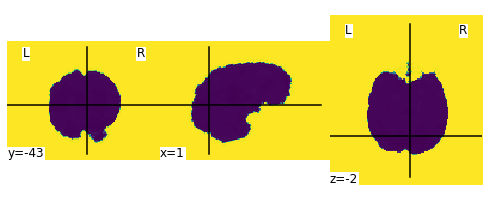

In [129]:
nilearn.plotting.plot_img(nilearn.image.mean_img(model00.predicted[0]))

In [131]:
import nilearn.decoding

# Define the cross-validation scheme used for validation.
# Here we use a KFold cross-validation on the session, which corresponds to
# splitting the samples in 4 folds and make 4 runs using each fold as a test
# set once and the others as learning sets
from sklearn.model_selection import KFold

import nilearn.decoding
# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = nilearn.decoding.SearchLight(
    mask_img=subject_data.mar_epi_mask,
    process_mask_img=nilearn.image.get_data(subject_data.mar_epi_mask).astype(np.int),
    radius=5.6,
    n_jobs=1,
    verbose=1,
    estimator=model00)
#     cv=KFold(n_splits=4))
# labels00 = subject_data00.events[['onset','duration','outcomes']].rename(columns={'outcomes':'trial_type'})
# 

In [132]:
help(searchlight.fit)

Help on method fit in module nilearn.decoding.searchlight:

fit(imgs, y, groups=None) method of nilearn.decoding.searchlight.SearchLight instance
    Fit the searchlight
    
    Parameters
    ----------
    imgs : Niimg-like object
        See http://nilearn.github.io/manipulating_images/input_output.html
        4D image.
    
    y : 1D array-like
        Target variable to predict. Must have exactly as many elements as
        3D images in img.
    
    groups : array-like, optional
        group label for each sample for cross validation. Must have
        exactly as many elements as 3D images in img. default None
        NOTE: will have no effect for scikit learn < 0.18



In [137]:
searchlight.fit(nilearn.image.concat_imgs(subject_data00.resampled_fmri_to_events[1],
                                          auto_resample=True),model00.predicted[0])

TypeError: Data given cannot be loaded because it is not compatible with nibabel format:
0

In [58]:
import pickle
with open(pjoin(datadir,subject_data.sub_id[0]+'_'+subject_data.sub_id[1][4:]), 'wb') as outp:
#     company1 = Company('banana', 40)
    pickle.dump(subject_data01, outp, pickle.HIGHEST_PROTOCOL)
outp.close()

#     company2 = Company('spam', 42)
#     pickle.dump(company2, outp, pickle.HIGHEST_PROTOCOL)

In [98]:
# Resample fmri volumes to the epi mask
resampled_imgs=[nilearn.image.resample_to_img(source_img=img,
                                              target_img=subject_data00.mar_epi_mask,force_resample=True)
                for img in tqdm(list(nilearn.image.iter_img(subject_data00.mar_scans.func[1][0])))]
# Clean the fmri volumes to increase SNR
cleaned_imgs=nilearn.image.clean_img(imgs=resampled_imgs,
                        detrend=True, 
                        standardize=True,
                        confounds=subject_data00.confounds,
                        low_pass=None, high_pass=None,
                        t_r=2.5,
                        ensure_finite=False,
                        mask_img=subject_data00.mar_epi_mask)
cleaned_fmri_imgs=list(nilearn.image.mean_img(img) for img in
                       tqdm(list(nilearn.image.iter_img(cleaned_imgs))))


100%|█████████████████████████████████████████| 288/288 [03:00<00:00,  1.59it/s]


In [96]:
# One subject fmri data
atlas_path=xpu('~/../../data/neuromod/DATA/DiFuMo/512/3mm/maps.nii.gz')
atlas_filename = nib.load(atlas_path)
labels = pd.read_csv(xpu('~/../../data/neuromod/DATA/DiFuMo/512/labels_512_dictionary.csv'))

# data,fmri_filenames=subject_data, cleaned_fmri_imgs

from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=nilearn.image.mean_img(atlas_filename),
                           labels=labels,
                           background_label=0,
                           mask_img=subject_data.mar_epi_mask,
                           smoothing_fwhm=9,
                           standardize=True,
                           standardize_confounds=True,
                           high_variance_confounds=True,
                           detrend=True,
                           low_pass=None, high_pass=None,
                           t_r=2.5, dtype=None,
                           resampling_target='data',
                           memory_level=1,
                           verbose=1, strategy='mean', reports=True)


#### Prepare fmri image file by resampling the time (4th) dimension to be the same as the number of trials

In [287]:
def resample_fmri_to_events(run_imgs, frame_times, n_events):
    decomp_func = df((img for img in
                     cleaned_fmri_imgs),
                     columns=['imgs'])
    decomp_func['frame_times'] = subject_data.frame_times
    test=df(pd.cut(decomp_func['frame_times'], subject_data.events.shape[0]))
    test['imgs'] = decomp_func['imgs']
    results = df(((grp, nilearn.image.mean_img(test.groupby('frame_times').get_group(grp)['imgs'])
        ) for grp in tqdm(list(test.groupby('frame_times').groups))))
    return results
test_results = resample_fmri_to_events(run_imgs=cleaned_imgs,
                                  frame_times=subject_data.frame_times,
                                  n_events=subject_data.events.shape[0])

100%|█████████████████████████████████████████| 120/120 [00:39<00:00,  3.03it/s]


In [ ]:
test_results01 = resample_fmri_to_events(run_imgs=cleaned_imgs,
                                  frame_times=subject_data01.frame_times,
                                  n_events=subject_data01.events.shape[0])

In [97]:
# X=[nilearn.image.get_data(val).flatten() for val
#    in subject_data.resampled_fmri_to_events.values]
# Y=subject_data.events.outcomes.values
X_train=[nilearn.image.get_data(val).flatten() for val
   in subject_data00.resampled_fmri_to_events[1].values]
Y_train=subject_data00.events.outcomes.fillna('ctl').values

X_test=[nilearn.image.get_data(val).flatten() for val
   in subject_data01.resampled_fmri_to_events[1].values]
Y_test=subject_data01.events.outcomes.fillna('ctl').values

# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test=train_test_split(X,Y)

In [98]:
from sklearn import tree
classifier=tree.DecisionTreeClassifier()
classifier.fit(X_train,Y_train)
predictions=classifier.predict(X_test)


In [99]:
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test,predictions))


0.2916666666666667


In [334]:
x_train,y_train

(array([<nibabel.nifti1.Nifti1Image object at 0x7fdf52ce62d0>,
       dtype=object),
 array(['miss', 'ctl', 'recog_ok_spatial_wrong', 'recog_ok_spatial_wrong',
        'recog_ok_spatial_wrong', 'hit', 'ctl', 'recog_ok_spatial_wrong',
        'recog_ok_spatial_wrong', 'recog_ok_spatial_wrong', 'hit', 'ctl',
        'hit', 'recog_ok_spatial_wrong', 'recog_ok_spatial_wrong', 'ctl',
        'ctl', 'recog_ok_spatial_wrong', 'ctl', 'recog_ok_spatial_wrong',
        'ctl', 'recog_ok_spatial_wrong', 'ctl', 'recog_ok_spatial_wrong',
        'ctl', 'miss', 'ctl', 'ctl', 'recog_ok_spatial_wrong', 'ctl',
        'ctl', 'ctl', 'recog_ok_spatial_wrong', 'hit',
        'recog_ok_spatial_wrong', 'recog_ok_spatial_wrong',
        'recog_ok_spatial_wrong', 'recog_ok_spatial_wrong',
        'recog_ok_spatial_wrong', 'hit', 'hit', 'ctl',
        'recog_ok_spatial_wrong', 'recog_ok_spatial_wrong',
        'recog_ok_spatial_wrong', 'hit', 'miss', 'hit', 'ctl', 'hit',
        'ctl', 'recog_ok_spatial_wrong',

In [223]:
frames = pd.Series(subject_data.resampled_frame_times)
train, test = sklearn.model_selection.train_test_split(pd.concat(
                   [results[1],frames, subject_data.events],axis=1).dropna(axis=0))
train.shape,test.shape

((57, 16), (20, 16))

In [152]:
from sklearn.datasets import make_multilabel_classification as make_multilabel
help(make_multilabel)

Help on function make_multilabel_classification in module sklearn.datasets._samples_generator:

make_multilabel_classification(n_samples=100, n_features=20, *, n_classes=5, n_labels=2, length=50, allow_unlabeled=True, sparse=False, return_indicator='dense', return_distributions=False, random_state=None)
    Generate a random multilabel classification problem.
    
    For each sample, the generative process is:
        - pick the number of labels: n ~ Poisson(n_labels)
        - n times, choose a class c: c ~ Multinomial(theta)
        - pick the document length: k ~ Poisson(length)
        - k times, choose a word: w ~ Multinomial(theta_c)
    
    In the above process, rejection sampling is used to make sure that
    n is never zero or more than `n_classes`, and that the document length
    is never zero. Likewise, we reject classes which have already been chosen.
    
    Read more in the :ref:`User Guide <sample_generators>`.
    
    Parameters
    ----------
    n_samples : int, 

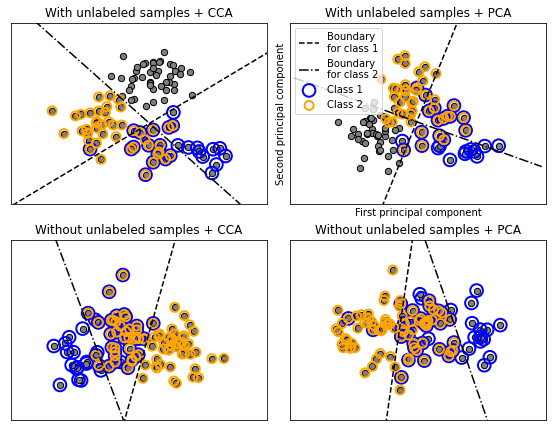

In [313]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA


def plot_hyperplane(clf, min_x, max_x, linestyle, label):
    # get the separating hyperplane
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(min_x - 5, max_x + 5)  # make sure the line is long enough
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.plot(xx, yy, linestyle, label=label)


def plot_subfigure(X, Y, subplot, title, transform):
    if transform == "pca":
        X = PCA(n_components=2).fit_transform(X)
    elif transform == "cca":
        X = CCA(n_components=2).fit(X, Y).transform(X)
    else:
        raise ValueError

    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])

    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])

    classif = OneVsRestClassifier(SVC(kernel='linear'))
    classif.fit(X, Y)

    plt.subplot(2, 2, subplot)
    plt.title(title)

    zero_class = np.where(Y[:, 0])
    one_class = np.where(Y[:, 1])
    plt.scatter(X[:, 0], X[:, 1], s=40, c='gray', edgecolors=(0, 0, 0))
    plt.scatter(X[zero_class, 0], X[zero_class, 1], s=160, edgecolors='b',
                facecolors='none', linewidths=2, label='Class 1')
    plt.scatter(X[one_class, 0], X[one_class, 1], s=80, edgecolors='orange',
                facecolors='none', linewidths=2, label='Class 2')

    plot_hyperplane(classif.estimators_[0], min_x, max_x, 'k--',
                    'Boundary\nfor class 1')
    plot_hyperplane(classif.estimators_[1], min_x, max_x, 'k-.',
                    'Boundary\nfor class 2')
    plt.xticks(())
    plt.yticks(())

    plt.xlim(min_x - .5 * max_x, max_x + .5 * max_x)
    plt.ylim(min_y - .5 * max_y, max_y + .5 * max_y)
    if subplot == 2:
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.legend(loc="upper left")


plt.figure(figsize=(8, 6))

X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=True,
                                      random_state=1)

plot_subfigure(X, Y, 1, "With unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 2, "With unlabeled samples + PCA", "pca")

X, Y = make_multilabel_classification(n_classes=2, n_labels=1,
                                      allow_unlabeled=False,
                                      random_state=1)

plot_subfigure(X, Y, 3, "Without unlabeled samples + CCA", "cca")
plot_subfigure(X, Y, 4, "Without unlabeled samples + PCA", "pca")

plt.subplots_adjust(.04, .02, .97, .94, .09, .2)
plt.show()

In [176]:
Decoder.get_params()

{'drift_model': 'cosine',
 'drift_order': 1,
 'fir_delays': [0],
 'high_pass': 0.01,
 'hrf_model': 'glover',
 'mask_img': <nibabel.nifti1.Nifti1Image at 0x7fdf4ff5c410>,
 'memory': Memory(location=None),
 'memory_level': 1,
 'min_onset': -24,
 'minimize_memory': False,
 'n_jobs': 1,
 'noise_model': 'ols',
 'signal_scaling': True,
 'slice_time_ref': 0.0,
 'smoothing_fwhm': 9.0,
 'standardize': False,
 'subject_label': 'sub-543589',
 't_r': 2.5000002,
 'target_affine': array([[-1.99247181e+00, -9.02319998e-02, -1.48034573e-01,
          1.37966904e+02],
        [-4.59029563e-02,  1.92138767e+00, -5.53319693e-01,
         -1.09609482e+02],
        [-1.67179346e-01,  5.47838867e-01,  1.91622782e+00,
         -9.18636551e+01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 'target_shape': (128, 128, 70),
 'verbose': 0}

100%|███████████████████████████████████████████| 19/19 [01:10<00:00,  3.71s/it]


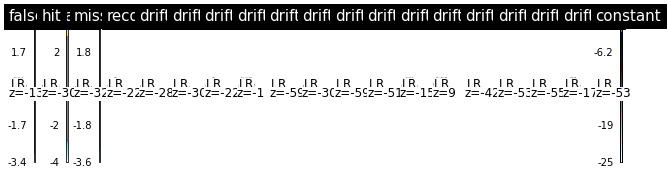

In [280]:
from nilearn import plotting
import numpy as np
import matplotlib.pyplot as plt

def make_localizer_contrasts(design_matrix):
    """ returns a dictionary of four contrasts, given the design matrix"""

    # first generate canonical contrasts
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])
    return contrasts

def plot_contrast(fit_model):
    """ Given a first model, specify, estimate and plot the main contrasts"""
    design_matrix = fit_model.design_matrices_[0]
    # Call the contrast specification within the function
    contrasts = make_localizer_contrasts(design_matrix)
    fig = plt.figure(figsize=(11, 3))
    # compute the per-contrast z-map
    for index, (contrast_id, contrast_val) in tqdm(list(enumerate(contrasts.items()))):
        ax = plt.subplot(1, len(contrasts), 1 + index)
        z_map = fit_model.compute_contrast(
            contrast_val, output_type='z_score')
        plotting.plot_stat_map(
            z_map, display_mode='z', threshold=3.0, title=contrast_id,
            axes=ax, cut_coords=1)

plot_contrast(fit_model)
plt.show()

In [183]:
# dir(Decoder)
decoder.get_params()
# (estimator='svc', mask=None, cv=10, param_grid=None, screening_percentile=20, scoring='roc_auc', smoothing_fwhm=None, standardize=True, target_affine=None, target_shape=None, mask_strategy='background', low_pass=None, high_pass=None, t_r=None, memory=None, memory_level=0, n_jobs=1, verbose=0)

{'cv': 10,
 'estimator__alphas': array([ 0.1,  1. , 10. ]),
 'estimator__class_weight': None,
 'estimator__cv': None,
 'estimator__fit_intercept': True,
 'estimator__normalize': False,
 'estimator__scoring': None,
 'estimator__store_cv_values': False,
 'estimator': RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ])),
 'high_pass': None,
 'low_pass': None,
 'mask': <nibabel.nifti1.Nifti1Image at 0x7fdf4ff5c410>,
 'mask_strategy': 'background',
 'memory': Memory(location=None),
 'memory_level': 0,
 'n_jobs': 1,
 'param_grid': None,
 'scoring': 'roc_auc_ovo',
 'screening_percentile': 20,
 'smoothing_fwhm': None,
 'standardize': True,
 't_r': None,
 'target_affine': None,
 'target_shape': None,
 'verbose': 0}

In [311]:
observed_timeseries = masker.fit_transform(results[1])
predicted_timeseries = masker.fit_transform(fit_model.predicted[0])

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(104, 123, 104),
affine=array([[   3.,    0.,    0.,  -96.],
       [   0.,    3.,    0., -132.],
       [   0.,    0.,    3.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(128, 128, 70),
affine=array([[-1.99247181e+00, -9.02319998e-02, -1.48034573e-01,
         1.37966904e+02],
       [-4.59029563e-02,  1.92138767e+00, -5.53319693e-01,
        -1.09609482e+02],
       [-1.67179346e-01,  5.47838867e-01,  1.91622782e+00,
        -9.18636551e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
)
[NiftiLabelsMasker.transform_single_imgs] Loading data from [Nifti1Image(
shape=(128, 128, 70),
affine=array([[-1.99247181e+00, -9.02319998e-02, -1.48034573e-01,
         1.37966904e+02],
       [-4.59029563e-02,  1.92138767e+00, -5.53319693e-01,
        -1.09609482e+02],
       [-1.67179346e-01,  5.47838867e-01,  1

[NiftiLabelsMasker.transform_single_imgs] Smoothing images
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(104, 123, 104),
affine=array([[   3.,    0.,    0.,  -96.],
       [   0.,    3.,    0., -132.],
       [   0.,    0.,    3.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(128, 128, 70),
affine=array([[-1.99247181e+00, -9.02319998e-02, -1.48034573e-01,
         1.37966904e+02],
       [-4.59029563e-02,  1.92138767e+00, -5.53319693e-01,
        -1.09609482e+02],
       [-1.67179346e-01,  5.47838867e-01,  1.91622782e+00,
        -9.18636551e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
)
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(128, 128, 70, 120),
affine=array([[-1.992

In [317]:
from nilearn.decoding import Decoder
decoder_params = dict(tuple(itm for itm in list(fit_model.get_params().items())
                            if itm[0] in list(decoder.get_params().keys())))
decoder = Decoder(estimator='svc_l1',
                  mask_strategy='epi',
#                   mask=subject_data.mar_epi_mask,
#                   standardize=True,
#                   scoring='roc_auc_ovo',
#                   probability=True,
#                   sparse=True,
                  **Decoder.set_params(decoder_params))
# predictions = decoder.predict(train[1])
# decoder.fit(results[1], list(nilearn.image.iter_img(fit_model.predicted[0])))
fitting = decoder.fit(test_results[1].values, subject_data.events.outcomes.values)
# prediction = decoder.predict(test[1])
# print(prediction)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [172]:
from nilearn.decoding import Decoder
decoder = Decoder(estimator='svc', mask=subject_data.mar_epi_mask, standardize=True)
decoder.fit(results[1], subject_data.events.outcomes)
# prediction = decoder.predict(results[1])
print(prediction)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [288]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5)

# The "cv" object's split method can now accept data and create a
# generator which can yield the splits.
fold = 0
for train, test in cv.split(conditions):
    fold += 1
    decoder = Decoder(estimator='svc', mask=masker, standardize=True)
    decoder.fit(index_img(fmri_niimgs, train), conditions[train])
    prediction = decoder.predict(index_img(fmri_niimgs, test))
    print(
        "CV Fold {:01d} | Prediction Accuracy: {:.3f}".format(
            fold,
            (prediction == conditions[test]).sum() / float(len(
                conditions[test]))))

NameError: name 'conditions' is not defined

In [159]:
# subject_data.events.outcomes=subject_data.events.outcomes.fillna('ctl')
classifier = make_multilabel(n_samples=90, n_features=20,
                                                n_classes=4,
                                                n_labels=1,
                                                length=20,
                                                allow_unlabeled=True,
                                                sparse=False,
                                                return_indicator='dense',
                                                return_distributions=True,
                                                random_state=None)
X, Y,p_c, p_w_c = classifier
# help(make_multilabel)

In [235]:
# smoothing fwhm value criterion
'''
Source: http://jpeelle.net/mri/image_processing/smoothing.html
One common rule of thumb is that, to render your data approximately normal,
you should smooth with a Gaussian filter approximately three times the size of your voxel.
If your voxel size is 3 x 3 x 3 mm, you would smooth with a 9 mm FWHM Gaussian filter.
'''
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
first_level_model = FirstLevelModel(t_r=subject_data.tr,
                                    slice_time_ref=0.0,
                                    hrf_model='glover',
                                    drift_model='cosine',
                                    high_pass=0.01,
                                    drift_order=1,
                                    fir_delays=[0],
                                    mask_img=subject_data.mar_epi_mask,
#                                     min_onset=train.onset.min,
                                    
                                    min_onset=subject_data.events.iloc[4].onset,
                                    
#                                     mask_img=subject_data.mar_epi_mask,
                                    target_affine=subject_data.mar_epi_mask.affine,
                                    target_shape=subject_data.mar_epi_mask.shape,
                                    smoothing_fwhm=dict(nib.load(subject_data.mar_scans.func[1][0]).header)['pixdim'][1]*3,
#                                     memory=Memory(location=None),
                                    memory_level=1,
                                    standardize=True,
                                    signal_scaling=0,
                                    noise_model='ols',
                                    verbose=0, n_jobs=1,
                                    minimize_memory=False,
                                    subject_label=subject_data.sub_id[0])


(120, 20)

<AxesSubplot:label='conditions', ylabel='scan number'>

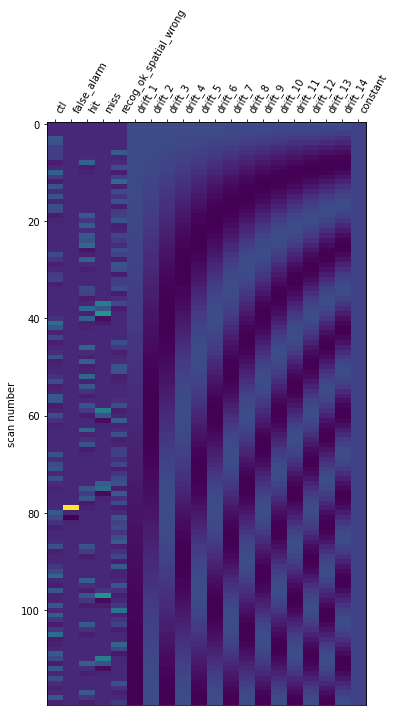

In [254]:
fmri_design_matrix = \
    make_first_level_design_matrix(
#         frame_times=train.dropna()[0],
#         frame_times=subject_data.resampled_frame_times,
        frame_times = subject_data.resampled_frame_times,
#         frame_times=np.arange(0, subject_data.frame_times.max(),
#                                           subject_data.frame_times.max()/subject_data.events.shape[0]),
#         events=subject_data.events[['onset','duration','trial_type']],
        events=subject_data.events[['onset','duration','outcomes']].rename(columns={'outcomes':'trial_type'}).sort_values('onset'),
#         events=train.dropna().iloc[:,2:][['onset','duration','outcomes']].rename(columns=({'outcomes':'trial_type'})),
        hrf_model='glover',
        drift_model='cosine',
        high_pass=0.01,
        drift_order=1,
        fir_delays=[0],
#         add_regs=behav_design_matrix.iloc[:,:3],
#         add_reg_names=list(behav_design_matrix.columns)[:3],
        oversampling=50)
# display(nilearn.plotting.plot_matrix(fmri_design_matrix),
display(fmri_design_matrix.shape,
        nilearn.plotting.plot_design_matrix(fmri_design_matrix))

In [239]:
fit_model=first_level_model.fit(run_imgs=results[1],
                      events=None,
                      design_matrices=fmri_design_matrix,
                      bins=fmri_design_matrix.shape[0])

In [255]:
# help(list(fit_model.__dict__['results_'][0].values())[0])
# list(fit_model.__dict__['results_'][0].values())[0].__dict__

In [246]:
# help(fit_model)
predicted,r_square,residuals = fit_model.predicted,fit_model.r_square,fit_model.residuals

In [33]:

enc_ctl_report=fit_model.generate_report(contrasts=list(fit_model.design_matrices_[0].columns[:4]),
#                                              ['enc-ctl','ctl-enc'],
                                         bg_img=subject_data.mar_epi_mask)
enc_ctl_report

drift_model,cosine
drift_order,1
fir_delays,[0]
high_pass (Hz),0.01
hrf_model,glover
noise_model,ols
scaling_axis,0
signal_scaling,True
slice_time_ref,0.0
smoothing_fwhm,9.0
standardize,False


In [110]:
from nilearn.decoding import Decoder
decoder=Decoder(estimator='svc',
                 mask=subject_data.mar_epi_mask,
                 cv=10,
                 param_grid=None,
                 screening_percentile=20,
                 scoring='roc_auc',
                 smoothing_fwhm=9,
                 standardize=True,
                 target_affine=None, target_shape=None,
                 mask_strategy='epi',
                 low_pass=None, high_pass=None, t_r=2.5,
                 memory=None, memory_level=0, n_jobs=1, verbose=1)


In [124]:
help(sklearn)

Help on package sklearn:

NAME
    sklearn

DESCRIPTION
    Machine learning module for Python
    
    sklearn is a Python module integrating classical machine
    learning algorithms in the tightly-knit world of scientific Python
    packages (numpy, scipy, matplotlib).
    
    It aims to provide simple and efficient solutions to learning problems
    that are accessible to everybody and reusable in various contexts:
    machine-learning as a versatile tool for science and engineering.
    
    See http://scikit-learn.org for complete documentation.

PACKAGE CONTENTS
    __check_build (package)
    _build_utils (package)
    _config
    _distributor_init
    _isotonic
    _loss (package)
    _min_dependencies
    base
    calibration
    cluster (package)
    compose (package)
    conftest
    covariance (package)
    cross_decomposition (package)
    datasets (package)
    decomposition (package)
    discriminant_analysis
    dummy
    ensemble (package)
    exceptions
    experime

In [123]:
dir(decoder)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_apply_mask',
 '_binarize_y',
 '_cache',
 '_check_n_features',
 '_decision_function',
 '_estimator_type',
 '_fetch_parallel_fit_outputs',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_output_image',
 '_predict_dummy',
 '_preprocess_data',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_set_intercept',
 '_validate_data',
 'clustering_percentile',
 'cv',
 'decision_function',
 'estimator',
 'fit',
 'get_params',
 'high_pass',
 'is_classification',
 'low_pass',
 'mask',
 'mask_strategy',
 'memory',
 'memory_level',
 'n_jobs',
 'para

In [121]:
# dir(decoder)
sorted(list(decoder.__dict__.keys()))

['clustering_percentile',
 'cv',
 'estimator',
 'high_pass',
 'is_classification',
 'low_pass',
 'mask',
 'mask_strategy',
 'memory',
 'memory_level',
 'n_jobs',
 'param_grid',
 'scoring',
 'screening_percentile',
 'smoothing_fwhm',
 'standardize',
 't_r',
 'target_affine',
 'target_shape',
 'verbose']

In [117]:
# y_pred = 
decoder.decision_function(X=results[1].values.tolist())

AttributeError: 'Decoder' object has no attribute 'coef_'

In [115]:
help(decoder)

Help on Decoder in module nilearn.decoding.decoder object:

class Decoder(_BaseDecoder)
 |  Decoder(estimator='svc', mask=None, cv=10, param_grid=None, screening_percentile=20, scoring='roc_auc', smoothing_fwhm=None, standardize=True, target_affine=None, target_shape=None, mask_strategy='background', low_pass=None, high_pass=None, t_r=None, memory=None, memory_level=0, n_jobs=1, verbose=0)
 |  
 |  A wrapper for popular classification strategies in neuroimaging.
 |  
 |  The `Decoder` object supports classification methods.
 |  It implements a model selection scheme that averages the best models
 |  within a cross validation loop. The resulting average model is the
 |  one used as a classifier. This object also leverages the`NiftiMaskers` to
 |  provide a direct interface with the Nifti files on disk.
 |  
 |  Parameters
 |  -----------
 |  estimator: str, optional
 |      The estimator to choose among: 'svc', 'svc_l2', 'svc_l1', 'logistic',
 |      'logistic_l1', 'logistic_l2' and 'ri

In [101]:
fit_masker=masker.fit()


[NiftiLabelsMasker.fit] loading data from Nifti1Image(
shape=(104, 123, 104),
affine=array([[   3.,    0.,    0.,  -96.],
       [   0.,    3.,    0., -132.],
       [   0.,    0.,    3.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit] loading data from Nifti1Image(
shape=(128, 128, 70),
affine=array([[-1.99247181e+00, -9.02319998e-02, -1.48034573e-01,
         1.37966904e+02],
       [-4.59029563e-02,  1.92138767e+00, -5.53319693e-01,
        -1.09609482e+02],
       [-1.67179346e-01,  5.47838867e-01,  1.91622782e+00,
        -9.18636551e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
)


In [81]:
time_series = masker.fit_transform(nilearn.image.concat_imgs(fmri_filenames, auto_resample=True),
                                   confounds=subject_data.confounds[['motion_tx', 'motion_ty',
                                                                         'motion_tz', 'motion_rx',
                                                                         'motion_ry', 'motion_rz']])

[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(104, 123, 104),
affine=array([[   3.,    0.,    0.,  -96.],
       [   0.,    3.,    0., -132.],
       [   0.,    0.,    3.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiLabelsMasker.fit_transform] loading data from Nifti1Image(
shape=(128, 128, 70),
affine=array([[-1.99824572e+00,  1.53470396e-07,  8.37512761e-02,
         1.27662941e+02],
       [-4.96683270e-03,  1.99647963e+00, -1.18508667e-01,
        -1.08048523e+02],
       [ 8.36038962e-02,  1.18612744e-01,  1.99472773e+00,
        -7.23150940e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
)
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(128, 128, 70, 310),
affine=array([[-1.99824572e+00,  1.53470396e-07,  8.37512761e-02,
         1.27662941e+02],
       [-4.96683270e-03,  1.99647963e+00, -1.18508667e-01,
        -1.08048523e+02],
       [ 8.36038962e-02,  1.18612744e-01

In [82]:
time_series.shape

(310, 64841)

In [83]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]

In [87]:
# help(nilearn.plotting.plot_matrix)
correlation_matrix.shape

(64841, 64841)

In [78]:
# correlation_matrix.shape,labels.shape
# 64841/512
# help(nilearn.plotting.plot_matrix)
# help()
np.fill_diagonal(correlation_matrix,0)
correlation_matrix.shape

(64841, 64841)

In [85]:
import numpy as np
from nilearn import plotting
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix,
                     figure=(10, 8),
                     labels=labels[1:],
                     vmax=0.8, vmin=-0.8,
                     reorder=True,
                     auto_fit=True)

ValueError: Length of labels unequal to length of matrix.

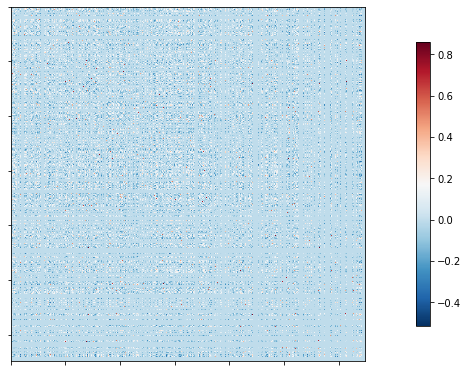

In [88]:
nilearn.plotting.plot_matrix(correlation_matrix)

In [31]:
# Prepare fmri image file by resampling the time (4th) dimension to be the same as the number of trials
decomp_func = df((img for img in
                 nilearn.image.iter_img(cleaned_imgs)),
                 columns=['imgs'])
decomp_func['frame_times'] = subject_data.frame_times
test=df(pd.cut(decomp_func['frame_times'], subject_data.events.shape[0]))
test['imgs'] = decomp_func['imgs']
results = df(((grp, nilearn.image.mean_img(test.groupby('frame_times').get_group(grp)['imgs'])
    ) for grp in tqdm(list(test.groupby('frame_times').groups))))
results[1]

100%|█████████████████████████████████████████| 120/120 [00:21<00:00,  5.51it/s]


0      <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1      <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
2      <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
3      <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
4      <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
                             ...                        
115    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
116    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
117    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
118    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
119    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
Name: 1, Length: 120, dtype: object

In [23]:
behavioral = subject_data.events

def get_events(behavioral:pd.DataFrame=subject_data.events,
               TR:float=subject_data.tr) -> dict:
    conditions = behavioral['outcomes'].values

    # Record these as an array of sessions
    sessions = behavioral['chunks'].values
    unique_sessions = behavioral['chunks'].unique()

    # fMRI data: a unique file for each session
    func_filename = haxby_dataset.func[0]
    events = {}
    # events will take  the form of a dictionary of Dataframes, one per session
    for session in unique_sessions:
        # get the condition label per session
        conditions_session = conditions[sessions == session]
        # get the number of scans per session, then the corresponding
        # vector of frame times
        n_scans = len(conditions_session)
        frame_times = TR * np.arange(n_scans)
        # each event last the full TR
        duration = TR * np.ones(n_scans)
        # Define the events object
        events_ = pd.DataFrame(
            {'onset': frame_times,
             'trial_type': conditions_session,
             'duration': duration})
        # remove the rest condition and insert into the dictionary
        events[session] = events_[events_.trial_type != 'rest']
    return events,sessions,unique_sessions
events,sessions,unique_sessions=get_events(behavioral)
events

KeyError: 'chunks'

In [21]:
# Instantiate the glm
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
first_level_model = FirstLevelModel(t_r=subject_data.tr,
                                    slice_time_ref=0.0,
                                    hrf_model='glover',
                                    drift_model='cosine',
                                    high_pass=0.01,
                                    drift_order=1,
                                    fir_delays=[0],
                                    min_onset=subject_data.events.iloc[3].onset,
                                    mask_img=subject_data.mar_epi_mask,
                                    target_affine=subject_data.mar_epi_mask.affine,
                                    target_shape=subject_data.mar_epi_mask.shape,
                                    smoothing_fwhm=dict(nib.load(subject_data.mar_scans.func[1][0]).header)['pixdim'][1]*3,
#                                     memory=Memory(location=None),
                                    memory_level=1,
                                    standardize=True,
                                    signal_scaling=0,
                                    noise_model='ols',
                                    verbose=0, n_jobs=1,
                                    minimize_memory=False,
                                    subject_label='_'.join([subject_data.sub_id[0],\
                                                            subject_data.sub_id[1]]))

In [22]:
# Prepare fmri image file by resampling the time (4th) dimension to be the same as the number of trials
decomp_func = df((img for img in
                 nilearn.image.iter_img(subject_data.mar_scans.func[1][0])),
                 columns=['imgs'])
decomp_func['frame_times'] = subject_data.frame_times
test=df(pd.cut(decomp_func['frame_times'], subject_data.events.iloc[4:,:].shape[0]))
test['imgs'] = decomp_func['imgs']
results = df(((grp, nilearn.image.mean_img(test.groupby('frame_times').get_group(grp)['imgs'])
    ) for grp in tqdm(list(test.groupby('frame_times').groups))))
results

100%|█████████████████████████████████████████| 116/116 [00:21<00:00,  5.48it/s]


,0,1
0,"(-0.772, 6.659]",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
1,"(6.659, 13.319]",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
2,"(13.319, 19.978]",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
3,"(19.978, 26.638]",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
4,"(26.638, 33.297]",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
...,...,...
111,"(739.202, 745.862]",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
112,"(745.862, 752.521]",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
113,"(752.521, 759.181]",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
114,"(759.181, 765.84]",<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


In [ ]:
from nilearn.image import index_img
def sessions_glm(events,sessions,unique_sessions):
    z_maps = []
    conditions_label = []
    session_label = []
    for session in unique_sessions:
        # grab the fmri data for that particular session
        fmri_session = index_img(func_filename, sessions == session)

        # fit the glm
        glm.fit(fmri_session, events=events[session])

        # set up contrasts: one per condition
        conditions = events[session].trial_type.unique()
        for condition_ in conditions:
            z_maps.append(glm.compute_contrast(condition_))
            conditions_label.append(condition_)
            session_label.append(session)
    return z_maps,conditions_label,session_label
z_maps,conditions_label,session_label=sessions_glm(events,sessions,unique_sessions)


In [92]:
# df(list(zip(subject_data.events.fix_onset.tolist(),
#                  ['fixation']*len(subject_data.events.fix_onset.tolist())))+\
#        list(zip(subject_data.events.onset.tolist(),
#                 ['enc']*len(subject_data.events.onset.tolist()))),
#    columns=['onset','condition']).set_index('onset').sort_index()

#[len(subject_data.events.fix_onset)*['fixation']]).reset_index()

,condition
onset,
4.595,enc
7.595,fixation
8.095,enc
11.095,fixation
11.595,enc
...,...
727.539,fixation
728.539,enc
731.538,fixation


In [79]:
# test=pd.concat([subject_data.events[['fix_onset','fix_duration','outcomes']].set_index('fix_onset'),
#         subject_data.events[['oldnumber','onset','duration','outcomes']].set_index('onset')]).sort_index()
# dict(zip(test.fix_duration))

In [52]:
# outcomes_map=dict(zip(subject_data.behav.oldnumber,
#          subject_data.behav.outcomes))
# subject_data.events['outcomes']=subject_data.events.oldnumber.map(outcomes_map).fillna('ctl')
# subject_data.events

In [93]:
# from nilearn.image import iter_img
# from nilearn.image import mean_img
eventsmatrix=df(tuple(zip(subject_data.events.outcomes,
   subject_data.events.onset,
   subject_data.events.oldnumber)), columns=['trial_type','onset','oldnumber'])
eventsmatrix.outcomes=eventsmatrix.trial_type.fillna('ctl')
eventsmatrix['intervals']=subject_data.resampled_frame_times
eventsmatrix['duration']=eventsmatrix.intervals.diff()
# eventsmatrix['frame_times']=frame_times
eventsmatrix.iloc[3:,:].reset_index(drop=True)

,trial_type,onset,oldnumber,intervals,duration
0,ctl,20.094,NaN,19.3125,6.4375
1,miss,23.594,old63,25.7500,6.4375
2,recog_ok_spatial_wrong,27.594,old02,32.1875,6.4375
3,miss,31.593,old17,38.6250,6.4375
4,recog_ok_spatial_wrong,36.093,old70,45.0625,6.4375
...,...,...,...,...,...
112,hit,703.041,old47,740.3125,6.4375
113,ctl,716.540,NaN,746.7500,6.4375
114,recog_ok_spatial_wrong,724.539,old23,753.1875,6.4375
115,recog_ok_spatial_wrong,728.539,old28,759.6250,6.4375


In [97]:
eventsmatrix['run_imgs']=results[1]
eventsmatrix.iloc[3:,:]

,trial_type,onset,oldnumber,intervals,duration,run_imgs
3,ctl,20.094,NaN,19.3125,6.4375,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
4,miss,23.594,old63,25.7500,6.4375,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
5,recog_ok_spatial_wrong,27.594,old02,32.1875,6.4375,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
6,miss,31.593,old17,38.6250,6.4375,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
7,recog_ok_spatial_wrong,36.093,old70,45.0625,6.4375,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
...,...,...,...,...,...,...
115,hit,703.041,old47,740.3125,6.4375,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
116,ctl,716.540,NaN,746.7500,6.4375,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
117,recog_ok_spatial_wrong,724.539,old23,753.1875,6.4375,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
118,recog_ok_spatial_wrong,728.539,old28,759.6250,6.4375,<class 'nibabel.nifti1.Nifti1Image'>\ndata sha...


(117, 20)

<AxesSubplot:label='conditions', ylabel='scan number'>

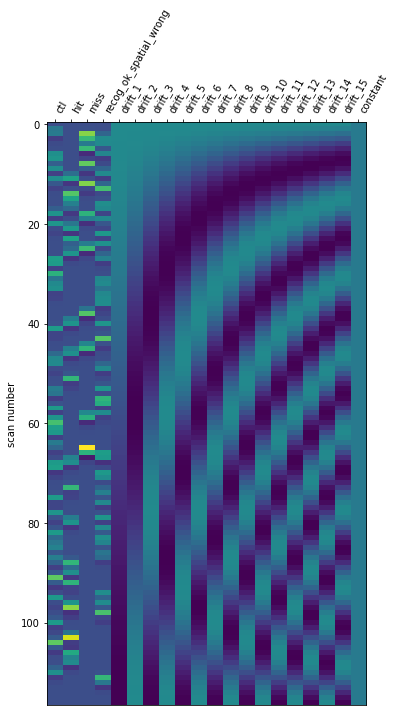

In [101]:
# smoothing fwhm value criterion
'''
Source: http://jpeelle.net/mri/image_processing/smoothing.html
One common rule of thumb is that, to render your data approximately normal,
you should smooth with a Gaussian filter approximately three times the size of your voxel.
If your voxel size is 3 x 3 x 3 mm, you would smooth with a 9 mm FWHM Gaussian filter.
'''
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
first_level_model = FirstLevelModel(t_r=subject_data.tr,
                                    slice_time_ref=0.0,
                                    hrf_model='glover',
                                    drift_model='cosine',
                                    high_pass=0.01,
                                    drift_order=1,
                                    fir_delays=[0],
#                                     min_onset=subject_data.events.iloc[4].onset,
#                                     mask_img=subject_data.mar_epi_mask,
                                    target_affine=subject_data.mar_epi_mask.affine,
                                    target_shape=subject_data.mar_epi_mask.shape,
                                    smoothing_fwhm=dict(nib.load(subject_data.mar_scans.func[1][0]).header)['pixdim'][1]*3,
#                                     memory=Memory(location=None),
                                    memory_level=1,
                                    standardize=True,
                                    signal_scaling=0,
                                    noise_model='ols',
                                    verbose=0, n_jobs=1,
                                    minimize_memory=False,
                                    subject_label=subject_data.sub_id[0])
fmri_design_matrix = \
    make_first_level_design_matrix(
        frame_times=subject_data.resampled_frame_times[3:],
        events=eventsmatrix[['onset', 'duration', 'trial_type']].iloc[3:,:],
        hrf_model='glover',
        drift_model='cosine',
        high_pass=0.01,
        drift_order=1,
        fir_delays=[0],
        oversampling=50)
display(fmri_design_matrix.shape,
        nilearn.plotting.plot_design_matrix(fmri_design_matrix))


In [104]:
fit_model=first_level_model.fit(run_imgs=concat_imgs(eventsmatrix.run_imgs[3:]),
                      design_matrices=fmri_design_matrix,
                      bins=fmri_design_matrix.shape[0])